In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import untils
from MiniDeepTaxonNet import CobwebNN, CobwebNNTreeLayer, TestModel
import argparse
import os
import sys

In [3]:
# load mnist
download = True
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# normalize
# mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))
# mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))

dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # random crop
    transforms.RandomAffine(degrees=20, translate=(0.1,0.1)),  # rotation & shift
    transforms.ToTensor(),
    # Normalization typical for MNIST
])
def simclr_transform(x):
    # We apply 'train_transform' twice to get two distinct views
    # from the same original image.
    return train_transform(x), train_transform(x)

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    # We'll override how __getitem__ works to produce two augmented views
    transform=None
)
# Because we want each sample to return a pair (x1, x2), we define a custom Dataset wrapper:
class SimCLRDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transform_fn):
        self.dataset = dataset
        self.transform_fn = transform_fn
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Apply our simclr_transform to get x1, x2
        x1, x2 = self.transform_fn(img)
        return x1, x2, label  # we can return the original label if needed (not used in unsupervised training)
    
    def __len__(self):
        return len(self.dataset)

train_dataset_simclr = SimCLRDatasetWrapper(train_dataset, simclr_transform)
mnist_simclr_train_loader = DataLoader(train_dataset_simclr, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)


In [14]:
# test with the autoencoder first
class testAE(nn.Module):
    def __init__(self):
        super(testAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            # nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            # nn.ReLU(),        
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# train the autoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = testAE().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

for epoch in range(num_epochs):
    for data in tqdm(mnist_train_loader):
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    # display 64 reconstructed images
    if epoch % 1 == 0:
        pic = output.cpu().data
        pic = pic.view(pic.size(0), 1, 28, 28)
        # matplotlib_imshow(torchvision.utils.make_grid(pic))
        # 8*8 subplots
        fig, axs = plt.subplots(8, 8, figsize=(20, 20))
        for i in range(8):
            for j in range(8):
                axs[i, j].imshow(pic[i*8+j].numpy().reshape(28, 28), cmap='gray')
                axs[i, j].axis('off')
        # save to /viz_out
        plt.savefig('viz_out/ae.png'.format(epoch))
        plt.close()
        # plt.show()



RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 768 samples in 0.000s...
[t-SNE] Computed neighbors for 768 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 768 / 768
[t-SNE] Mean sigma: 6.872048
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.884258
[t-SNE] KL divergence after 1000 iterations: 0.964233


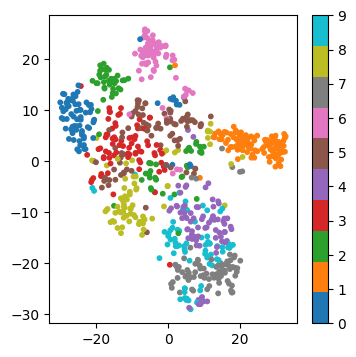

In [ ]:
# visualize t-sne on learned features
# get the learned features
model.eval()
features = []
labels = []
for i, data in enumerate(mnist_train_loader):
    img, label = data
    img = img.to(device)
    img = img.view(img.size(0), -1)
    output = model.encoder(img)
    features.append(output.cpu().detach().numpy())
    labels.append(label.numpy())
    if i > 4:
        break
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# t-sne
tsne = TSNE(n_components=2, verbose=1, perplexity=40)
tsne_results = tsne.fit_transform(features)
plt.figure(figsize=(4, 4))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar()
plt.show()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a subset of the data
subset = [4, 9]
# 
# subset = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_data = untils.filter_by_label(mnist_train, subset, rename_labels=True)
test_data = untils.filter_by_label(mnist_test, subset, rename_labels=True)
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)


100%|██████████| 10000/10000 [00:00<00:00, 12733.87it/s]


In [5]:
# centroid entropy
# randomly sample 100 images from each class
# data: list of (img, label)
class_1 = random.sample([data for data in train_data if data[1] == 0], 500)
class_2 = random.sample([data for data in train_data if data[1] == 1], 500)
# print(len(11791))
# random sample 100 images from all data
# class_1 = random.sample(train_data, 500)
# class_2 = random.sample(train_data, 500)


sample_1 = torch.stack([data[0].flatten() for data in class_1], dim=0)
sample_2 = torch.stack([data[0].flatten() for data in class_2], dim=0)

mu_1 = sample_1.mean(dim=0)
# print(mu_1)
diagvar_1 = sample_1.var(dim=0) + 1e-3
# print(diagvar_1)
mu_2 = sample_2.mean(dim=0)
diagvar_2 = sample_2.var(dim=0) + 1e-3

# kl div
def kl_div(mu1, diagvar1, mu2, diagvar2, eps=1e-6):
    logvar1 = torch.log(diagvar1)
    logvar2 = torch.log(diagvar2)
    kl_elements = 0.5 * (logvar2 - logvar1 + (diagvar1 + (mu1 - mu2)**2) / (diagvar2 + eps) - 1)
    return kl_elements.sum()

kl = kl_div(mu_1, diagvar_1, mu_2, diagvar_2)
print(kl.item())

12148.845703125


In [16]:
def viz():   # pass the train data and plot the latent representation
    all_latent = []
    all_labels = []
    all_nodes = []

    with torch.no_grad():
        for j, (data, target) in enumerate(test_loader):
            data = data.to(device)
            data = data.expand(-1, 3, -1, -1)
            x, means, logvars, x_preds, p_x_nodes, p_node_xs, x_latent, x_sampled = DTN(data)
            all_latent.append(x_sampled.cpu().detach().numpy())
            all_labels.append(target.cpu().detach().numpy())
            if j > 1:
                break
        # all_nodes.append(means)
    all_nodes = torch.cat(means, dim=0)

    all_latent = np.concatenate(all_latent, axis=0)
    n_latent = all_latent.shape[0]
    all_labels = np.concatenate(all_labels, axis=0)
    all_nodes = all_nodes.cpu().detach().numpy()
    # print(all_nodes.shape)
    # print(all_latent.shape)

    # append all_nodes to all_latent
    all_latent = np.concatenate([all_latent, all_nodes], axis=0)
    # extend all_labels
    all_labels = np.concatenate([all_labels, np.repeat(2, all_nodes.shape[0])], axis=0)
    # plt.scatter(all_latent[:, 0], all_latent[:, 1], c=all_labels, cmap='tab10')
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(all_latent)
    plt.scatter(X_tsne[:n_latent, 0], X_tsne[:n_latent, 1], c=all_labels[:n_latent], cmap='tab10', s=20)
    plt.scatter(X_tsne[n_latent:, 0], X_tsne[n_latent:, 1], c='black', s=5)
    # plt.show()
    plt.savefig('viz_out/latent.png')
    plt.close()

In [17]:
def plot_consistency():
    # plot the consistency of the nodes
    # get the consistency of the nodes
    all_consistency = []
    all_targets = []
    with torch.no_grad():
        for j, (data, target) in enumerate(train_loader):
            data = data.to(device)
            data = data.expand(-1, 3, -1, -1)
            x, means, logvars, x_preds, p_x_nodes, p_node_xs, x_latent, x_sampled = DTN(data)
            all_consistency.append(p_node_xs)
            all_targets.append(target)
            if j > 1:
                break
    all_consistency = torch.cat(all_consistency, dim=0)
    # print(all_consistency.shape)
    all_targets = torch.cat(all_targets, dim=0)
    all_consistency = all_consistency.cpu().detach().numpy()
    all_targets = all_targets.cpu().detach().numpy()

    # plot the consistency in a confusion matrix.
    # 2 x 2 matrix, each cell is the count of that label in that node
    # get the counts
    counts = np.zeros((2, 2))
    for i in range(all_targets.shape[0]):
        counts[all_targets[i], np.argmax(all_consistency[i])] += 1
    # print(counts)
    fig, ax = plt.subplots()
    im = ax.imshow(counts, cmap='viridis')
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['node 0', 'node 1'])
    ax.set_yticklabels(['label 0', 'label 1'])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, counts[i, j], ha='center', va='center', color='w')
    fig.tight_layout()
    plt.savefig('viz_out/consistency.png')
    plt.close()
    

In [18]:
def plot_loss(losses: list, loss_name: list):
    # create subplots of len(losses)
    fig, axs = plt.subplots(1, len(losses), figsize=(10, 3))
    for i in range(len(losses)):
        axs[i].plot(losses[i])
        axs[i].set_title(loss_name[i])
    plt.savefig('viz_out/loss.png')
    plt.close()

In [25]:

n_layers = 1
n_hidden = 32
input_dim = 28*28
tau = 0.2
commitment_weight = 0.25
sampling = False
kl_weight = 1
DTN = CobwebNN(input_dim=input_dim, n_layers=n_layers, n_hidden=n_hidden,
                  disable_decoder_sigmoid=False, tau=tau, 
                  layer_wise=False, sampling=sampling, simple_encoder=True
                  ).to(device)

optimizer = optim.Adam(DTN.parameters(), lr=2e-4, weight_decay=1e-5)



# dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [26]:
steps = 0
# create a dataloader form X and y
total_loss = []

CONTRAS = []
CMTs = []
RECs = []
KLs = []
MIs = []

means = []
logvars = []

# kl div
def kl_div(mu1, logvar1, mu2, logvar2, eps=1e-6):
    # logvar1 = torch.log(diagvar1)
    diagvar1 = torch.exp(logvar1)
    # logvar2 = torch.log(diagvar2)
    diagvar2 = torch.exp(logvar2)
    kl_elements = 0.5 * (logvar2 - logvar1 + (diagvar1 + (mu1 - mu2)**2) / (diagvar2 + eps) - 1)
    return kl_elements.sum()

def entropy(q):
    # shape: batch, n_clusters
    N = q.size(0)
    # marginalize over the batch
    q_bar = q.mean(dim=0)
    H_marginal = -torch.sum(q_bar * torch.log(q_bar + 1e-6))
    H_cond = -torch.mean(torch.sum(q * torch.log(q + 1e-6), dim=1))
    MI = H_marginal - H_cond
    return MI

def dec_loss(q):
    # q: shape: batch, n_clusters
    freq = q.sum(dim=0) # shape: n_clusters
    # raise q to the power of 2
    q2 = q.pow(2) / freq # shaq: batch, n_clusters
    # normalize
    q2 = q2 / q2.sum(dim=1, keepdim=True)
    # KL betweem q and q^2
    kl = torch.sum(q2 * (torch.log(q2 + 1e-6) - torch.log(q + 1e-6)))


    return kl

epochs = 2000
for epoch in range(epochs):
    if epoch % 50 == 0:
        print(f'Epoch {epoch}')
    if epoch % 2 == 0:
        viz()
        # plot_consistency()
    for j, (data, target) in enumerate(train_loader):
    # for j, (x1, x2, target) in enumerate(mnist_simclr_train_loader):\
        # cobweb.train()
        optimizer.zero_grad()

        data = data.to(device)#.view(-1, 28*28)
        data = data.expand(-1, 3, -1, -1)
        x, means, logvars, x_preds, p_x_nodes, p_node_xs, x_latent, z_hat = DTN(data)
        # print(means[0][0])
        loss = 0
        PTY = 0
        CMT = 0
        REC = 0
        KL = 0
        # break
        H = 0
        ########### tree-wise loss ############

            # means: 2**n_layers-1, n_hidden
            # logvars: 2**n_layers-1, n_hidden
            # x_preds: B, 512, 1, 1
            # p_node_xs: B, 2**n_layers-1
            # reconstruction loss
        REC = F.mse_loss(x_preds, data)
        # prototype loss
        # PTY = ((x_latent.detach().unsqueeze(1) - torch.cat(means, dim=0).unsqueeze(0)).pow(2).mean(dim=-1) * p_node_xs).sum(dim=-1).mean()
        # commitment loss
        # CMT = ((x_latent.unsqueeze(1) - torch.cat(means, dim=0).detach().unsqueeze(0)).pow(2).mean(dim=-1) * p_node_xs).sum(dim=-1).mean()
        if False:
            # maximize the logprob of x_latent given the means and logvars
            #  dist = -0.5 * torch.sum(logvars_cat + ((x_mu.unsqueeze(1) - means_cat.unsqueeze(0)) ** 2) / torch.exp(logvars_cat), dim=-1)
            CMT += 0.5 * torch.sum(torch.cat(logvars, dim=0) + 1e-6 + ((x_latent.unsqueeze(1) - torch.cat(means, dim=0).unsqueeze(0)) ** 2) / torch.exp(torch.cat(logvars, dim=0) + 1e-6), dim=-1).mean()
        else:
            CMT += ((x_latent.unsqueeze(1) - torch.cat(means, dim=0).unsqueeze(0)).pow(2).mean(dim=-1) * p_node_xs).sum(dim=-1).mean()
        KL = untils.cross_entropy_regularization(p_node_xs, depth=n_layers + 1, lambda_=kl_weight, entire_tree=True)
        
        # contrastive loss on cluster
        x_latent_norm = F.normalize(x_latent, dim=1)
        # print(f"range: {torch.min(x_latent_norm)}, {torch.max(x_latent_norm)}")
        z_hat_norm = F.normalize(z_hat, dim=1)
        # print(f"range: {torch.min(z_hat_norm)}, {torch.max(z_hat_norm)}")
        z = torch.cat([x_latent_norm, z_hat_norm], dim=0) # shape: 2B, 32
        sim = torch.mm(z, z.t()) # shape: 2B, 2B
        sim /= 0.5
        # print(sim.shape)
        batch_range = torch.arange(z_hat_norm.size(0), device=z_hat_norm.device) # 0 to B
        positive_idx = torch.cat([batch_range + z_hat_norm.size(0), batch_range], dim=0).to(device) # B to 2B and 0 to B
        # print(positive_idx)
        loss_mask = torch.eye(2 * z_hat_norm.size(0), device=z_hat_norm.device).bool()
        sim.masked_fill_(loss_mask, float('-inf'))

        labels = positive_idx
        CONTRASTIVE = F.cross_entropy(sim, labels)

        # MI_KL = -kl_div(means[0][0], logvars[0][0], means[0][1], logvars[0][1])
        MI = -entropy(p_node_xs)

        # DEC loss: KL between p_node_xs and p_node_xs^2
        DEC = dec_loss(p_node_xs)
        # print(DEC)
        # break
        # print(MI)
        # break
        # print(f"Contrastive loss: {CONTRASTIVE.item()}")
        # break
        # loss = REC + commitment_weight * CMT + KL + CONTRASTIVE
        loss = REC + commitment_weight * CMT + MI + CONTRASTIVE# + 0.1 * CONTRASTIVE
        CMTs.append(CMT.item())
        MIs.append(MI.item())
        RECs.append(REC.item())
        KLs.append(KL.item())
        CONTRAS.append(CONTRASTIVE.item())


        if j % 50 == 0:
            plot_loss([CMTs, RECs, CONTRAS, MIs], ['CMT', 'REC', 'CONTRAS', 'MI'])
            # print(p_node_xs.shape)
            # print(torch.cat(means, dim=0).shape)

        loss.backward()
        optimizer.step()
        steps += 1
        total_loss.append(loss.item())
    # print(f"Loss: {loss.item()}") 

plt.plot(total_loss)

Epoch 0


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/nethome/zwang910/miniconda3/envs/dl/l

KeyboardInterrupt: 